In [1]:
import numpy as np
import os
import yaml
import sys
import torch
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# change dir to parent
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
# Load configuration from YAML
img_config = os.getcwd() + "/config.yaml"
seg_config = os.getcwd() + "/config_labels.yaml"
with open(img_config, 'r') as f:
    img_config = yaml.safe_load(f)
with open(seg_config, 'r') as f:
    seg_config = yaml.safe_load(f)

In [3]:
image_vqvae_ckpt = '/vol/aimspace/projects/practical_WS2425/diffusion/code/vqvae/runs/vqvae/vqvae-32x32x4-amos-images/checkpoints/last.ckpt'
label_vqvae_ckpt = '/vol/aimspace/projects/practical_WS2425/diffusion/code/vqvae/runs/vqvae_labels/vqvae-32x32x4-amos-labels/checkpoints/last.ckpt'

In [4]:
from main import VQVAETrainingModule
from utils.utils import load_amos


# Load data using utility function
training_data, validation_data, training_loader, validation_loader = load_amos(
    img_config["dataset"]
)
seg_vae = VQVAETrainingModule.load_from_checkpoint(label_vqvae_ckpt)
img_vae = VQVAETrainingModule.load_from_checkpoint(image_vqvae_ckpt)
img_encoder = img_vae.model.encoder 
seg_encoder = seg_vae.model.encoder
img_preqconv = img_vae.model.pre_quantization_conv
seg_preqconv = seg_vae.model.pre_quantization_conv
img_vecquant = img_vae.model.vector_quantization
seg_vecquant = seg_vae.model.vector_quantization

img_embedder = torch.nn.Sequential(img_encoder, img_preqconv, img_vecquant)
seg_embedder = torch.nn.Sequential(seg_encoder, seg_preqconv, seg_vecquant)

Loading Amos train data


/vol/aimspace/projects/practical_WS2425/diffusion/code/vqvae/utils/amos.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  labels_df = labels_df[combined_mask]


Loaded 87480 train images
Transforms: Compose(
    ToTensor()
    Resize(size=512, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(512, 512))
    Normalize(mean=0.5, std=0.5)
), index_range: range(0, 501), slice_range: None, only_labeled: False
Loading Amos val data
Loaded 44032 val images
Transforms: Compose(
    ToTensor()
    Resize(size=512, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(512, 512))
    Normalize(mean=0.5, std=0.5)
), index_range: range(0, 501), slice_range: None, only_labeled: False
Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 128, 64, 64]         --
|    └─Sequential: 2-1                   [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        1,088
|    |    └─ReLU: 3-2                    [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-3                  [-1, 64, 128, 128]        65,600
| 

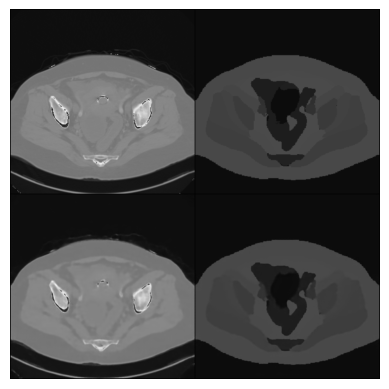

In [5]:
img_encoder.eval()
seg_encoder.eval()


device = "cuda" if torch.cuda.is_available() else "cpu"

batch = validation_data[1]
img, seg = batch["image"], batch["label"]
img = img.to(device)[0].view(1, 512, 512)
seg = seg.to(device)[0].view(1, 512, 512)


img_recon = img_vae.model(img.unsqueeze(0))[1].flatten(0,1)
seg_recon = seg_vae.model(seg.unsqueeze(0))[1].flatten(0,1)

# make grid
grid = make_grid([img, seg, img_recon, seg_recon], nrow=2, normalize=True, scale_each=False)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [6]:
seg_np = np.array(seg.cpu().detach())
seg_recon_np = np.array(seg_recon.cpu().detach())


seg_recon_np = seg_recon_np - seg_recon_np.min()
seg_recon_np = seg_recon_np / seg_recon_np.max() * 73
seg_recon_np

array([[[7.0362988, 7.6654587, 7.569493 , ..., 6.0276027, 7.744041 ,
         9.313698 ],
        [5.7461886, 7.3251963, 7.665836 , ..., 6.669957 , 6.7744203,
         7.229674 ],
        [7.714375 , 7.8273544, 6.2148495, ..., 8.283164 , 6.501689 ,
         7.7033834],
        ...,
        [7.3638754, 7.5766397, 6.839245 , ..., 6.7837377, 7.161541 ,
         7.0364842],
        [5.7447333, 6.064025 , 7.685099 , ..., 7.6155634, 6.9378977,
         7.9169483],
        [9.290127 , 6.32683  , 6.107117 , ..., 6.8611484, 6.8071504,
         8.091337 ]]], dtype=float32)

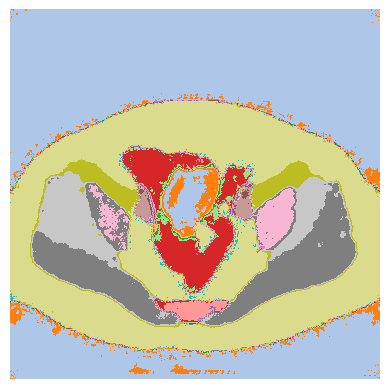

In [7]:

mask = np.abs(seg_np - seg_recon_np)
plt.imshow(seg_recon_np[0], cmap='tab20')
plt.axis('off')
plt.show()

## Perform forward for images and labels

In [8]:
from itertools import product
from torchvision import transforms
from utils.amos import AmosDataset
from tqdm import tqdm

In [26]:
batch = validation_data[1]
img, seg = batch["image"], batch["label"]
img = img.to(device)
seg = seg.to(device)

img.unsqueeze(0).shape

img_recon = img_embedder(img.unsqueeze(0))[1].flatten(0,1)
seg_recon = seg_embedder(seg.unsqueeze(0))[1].flatten(0,1)
img_recon.shape


torch.Size([32, 64, 64])

In [10]:
in_dir = '/vol/aimspace/projects/practical_WS2425/diffusion/data/amos_robert_slices/'
out_dir = '/vol/aimspace/projects/practical_WS2425/diffusion/data/amos_robert_embeddings/'

device = "cuda" if torch.cuda.is_available() else "cpu"

splits = ['train', 'val']

for split in splits:
    print(split)
    ds = AmosDataset(
        os.path.join(in_dir),
        split,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize(512),
                transforms.CenterCrop(512),
                transforms.Normalize(0.5, 0.5),
            ]
        ),
        index_range=(0, 500),
        slice_range=None,
        only_labeled=False,
    )
    dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=False)
    
    for batch in dl:
        img, seg = batch["image"], batch["label"]
        img = img.to(device)
        seg = seg.to(device)
        img_embedding = img_embedder(img)
        seg_embedding = seg_embedder(seg)
        print(img_embedding.shape)  
        break
    break

    os.makedirs(os.path.join(out_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(out_dir, 'labels', split), exist_ok=True)
    for batch in tqdm(ds):
        img, seg = batch["image"], batch["label"]
        img = img.to(device)[0].view(1, 512, 512)
        seg = seg.to(device)[0].view(1, 512, 512)

        img_embedding = img_embedder(img.unsqueeze(0))
        seg_embedding = seg_embedder(seg.unsqueeze(0))

        img_embedding_np = np.array(img_embedding.cpu().detach())
        seg_embedding_np = np.array(seg_embedding.cpu().detach())
        
        torch.save(img_embedding_np, os.path.join(out_dir, 'images', split, f'{batch["name"]}.pt'))
        torch.save(seg_embedding_np, os.path.join(out_dir, 'labels', split, f'{batch["name"]}.pt'))

train
Loading Amos train data


/vol/aimspace/projects/practical_WS2425/diffusion/code/vqvae/utils/amos.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  labels_df = labels_df[combined_mask]


Loaded 87480 train images
Transforms: Compose(
    ToTensor()
    Resize(size=512, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(512, 512))
    Normalize(mean=0.5, std=0.5)
), index_range: range(0, 501), slice_range: None, only_labeled: False


KeyboardInterrupt: 

In [76]:
list(product(folders, splits))

[('images', 'train'),
 ('images', 'val'),
 ('labels', 'train'),
 ('labels', 'val')]

In [56]:
!ls /vol/aimspace/projects/practical_WS2425/diffusion/data/amos_robert_slices/

images	  imagesVa  labelsTr	    labelsVa
imagesTr  labels    labelsTr_axial  labelsVa_axial
